In [63]:
import pandas as pd
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [64]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [65]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [66]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TSMixerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=27,
        output_chunk_length=1,
        hidden_size=128,
        activation="ReLU",
        num_blocks=1,
        norm_type="TimeBatchNorm2d",
        ff_size=132,
        normalize_before=True,
        n_epochs=100,
        batch_size=67,
        dropout=0.45087323478159125,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.004216838508548973, "weight_decay": 0.000358724351349336}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.062
Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 0.032
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.030
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.026
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.018
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.018. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     9.565451    3.092806    2.488599  0.808715   
Precipitation_accumulated       0.262497    0.512345    0.425182  0.582970   
Humidity                      122.083333   11.049133    8.828237  0.610531   
Wind_Speed_kmh                  0.495554    0.703956    0.578817 -0.171042   
Soil_Moisture              134554.792263  366.817110  237.483174  0.782805   
Soil_Temperature               16.571070    4.070758    3.080524  0.771855   
Wind_Dir_Sin                    0.305091    0.552351    0.447681  0.045880   
Wind_Dir_Cos                    0.432336    0.657523    0.511843 -0.118163   

                                SMAPE  
Temperature                 15.447516  
Precipitation_accumulated   13.301030  
Humidity                    12.725752  
Wind_Speed_kmh              65.297470  
Soil_Mo

Metric val_loss improved. New best score: 6.334
Monitored metric val_loss did not improve in the last 10 records. Best score: 6.334. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE          RMSE           MAE  \
Temperature                7.412789e+02     27.226437     23.548375   
Precipitation_accumulated  9.009553e+04    300.159179    256.932944   
Humidity                   2.026425e+05    450.158350    384.395607   
Wind_Speed_kmh             4.913964e+02     22.167462     18.909138   
Soil_Moisture              8.292027e+08  28795.879047  24538.967262   
Soil_Temperature           2.678753e+03     51.756669     44.303225   
Wind_Dir_Sin               1.324741e+02     11.509737      9.890335   
Wind_Dir_Cos               4.167545e+01      6.455653      5.554544   

                                    R2       SMAPE  
Temperature                 -20.340820   74.768082  
Precipitation_accumulated    -1.267336  105.704548  
Humidity                  -1611.222912  113.077609  
Wind_Speed_kmh            -1501.368911  152.300995  
Soil_

Metric val_loss improved. New best score: 0.013
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE            R2  \
Temperature                    1.757769    1.325809   1.003264  6.850820e-01   
Precipitation_accumulated    325.705772   18.047320  14.678309 -2.748648e+06   
Humidity                       8.759815    2.959698   2.241445  4.904882e-01   
Wind_Speed_kmh                 0.187217    0.432686   0.415755          -inf   
Soil_Moisture              14347.341006  119.780387  85.329931 -9.736491e+00   
Soil_Temperature               2.357200    1.535318   1.121087  6.276689e-01   
Wind_Dir_Sin                   0.009269    0.096276   0.075736          -inf   
Wind_Dir_Cos                   0.017212    0.131194   0.109678          -inf   

                                SMAPE  
Temperature                  7.012413  
Precipitation_accumulated    3.128827  
Humidity                     2.588001  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encount

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    0.896570    0.946874    0.754724 -5.845386e-01   
Precipitation_accumulated    543.351357   23.309898   22.173961 -1.645198e+04   
Humidity                       8.877596    2.979529    2.548128  8.839618e-02   
Wind_Speed_kmh                 0.022003    0.148333    0.114908          -inf   
Soil_Moisture              31235.865358  176.736712  127.376174  1.016566e-01   
Soil_Temperature               0.726286    0.852224    0.687309 -2.189088e+00   
Wind_Dir_Sin                   0.002009    0.044824    0.036610          -inf   
Wind_Dir_Cos                   0.008584    0.092651    0.080824          -inf   

                                SMAPE  
Temperature                  7.727547  
Precipitation_accumulated    4.970576  
Humidity                     2.821517  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    1.103709    1.050575    0.804055     0.535390   
Precipitation_accumulated    815.828577   28.562713   28.066238 -2872.133057   
Humidity                      53.478996    7.312933    6.659693    -0.144470   
Wind_Speed_kmh                 0.070966    0.266394    0.208041   -33.193252   
Soil_Moisture              55207.627261  234.963034  194.868157    -5.874250   
Soil_Temperature               0.660877    0.812944    0.679738     0.592416   
Wind_Dir_Sin                   0.025525    0.159765    0.119170     0.557911   
Wind_Dir_Cos                   0.031389    0.177170    0.086218     0.644308   

                                SMAPE  
Temperature                 11.681517  
Precipitation_accumulated    5.928579  
Humidity                     7.758979  
Wind_Speed_kmh             18

Metric val_loss improved. New best score: 0.036
Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many wor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     2.733938    1.653462    1.321118     0.708205   
Precipitation_accumulated    1612.129052   40.151327   31.197248 -1390.204308   
Humidity                       23.922098    4.891022    3.849731     0.792708   
Wind_Speed_kmh                  0.511031    0.714865    0.510294     0.671506   
Soil_Moisture              105365.337329  324.600273  259.158788     0.918007   
Soil_Temperature                6.955137    2.637259    2.178272    -0.382483   
Wind_Dir_Sin                    0.344908    0.587289    0.427652     0.278587   
Wind_Dir_Cos                    0.269959    0.519576    0.399213     0.445740   

                                SMAPE  
Temperature                 38.334595  
Precipitation_accumulated    7.154658  
Humidity                     4.232097  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.026
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.011
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   3.016666   1.736855   1.439320    0.888524   
Precipitation_accumulated    91.175525   9.548588   8.911121 -305.172300   
Humidity                     12.089265   3.476962   2.643136    0.920098   
Wind_Speed_kmh                0.543151   0.736988   0.565574    0.548403   
Soil_Moisture              4832.301640  69.514758  59.235874    0.183998   
Soil_Temperature              1.760286   1.326758   1.040076    0.842279   
Wind_Dir_Sin                  0.380732   0.617035   0.478577    0.289155   
Wind_Dir_Cos                  0.299972   0.547697   0.444347    0.117357   

                                SMAPE  
Temperature                 16.493637  
Precipitation_accumulated    1.892295  
Humidity                     3.249737  
Wind_Speed_kmh              54.479455  
Soil_Moisture            

In [67]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TSMixerModel(output_chunk_shift=0, hidden_size=128, ff_size=132, num_blocks=1, activation=ReLU, dropout=0.45087323478159125, norm_type=TimeBatchNorm2d, normalize_before=True, use_static_covariates=True, model_name=model_1, input_chunk_length=27, output_chunk_length=1, n_epochs=100, batch_size=67, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f9df9195af0>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0

In [68]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


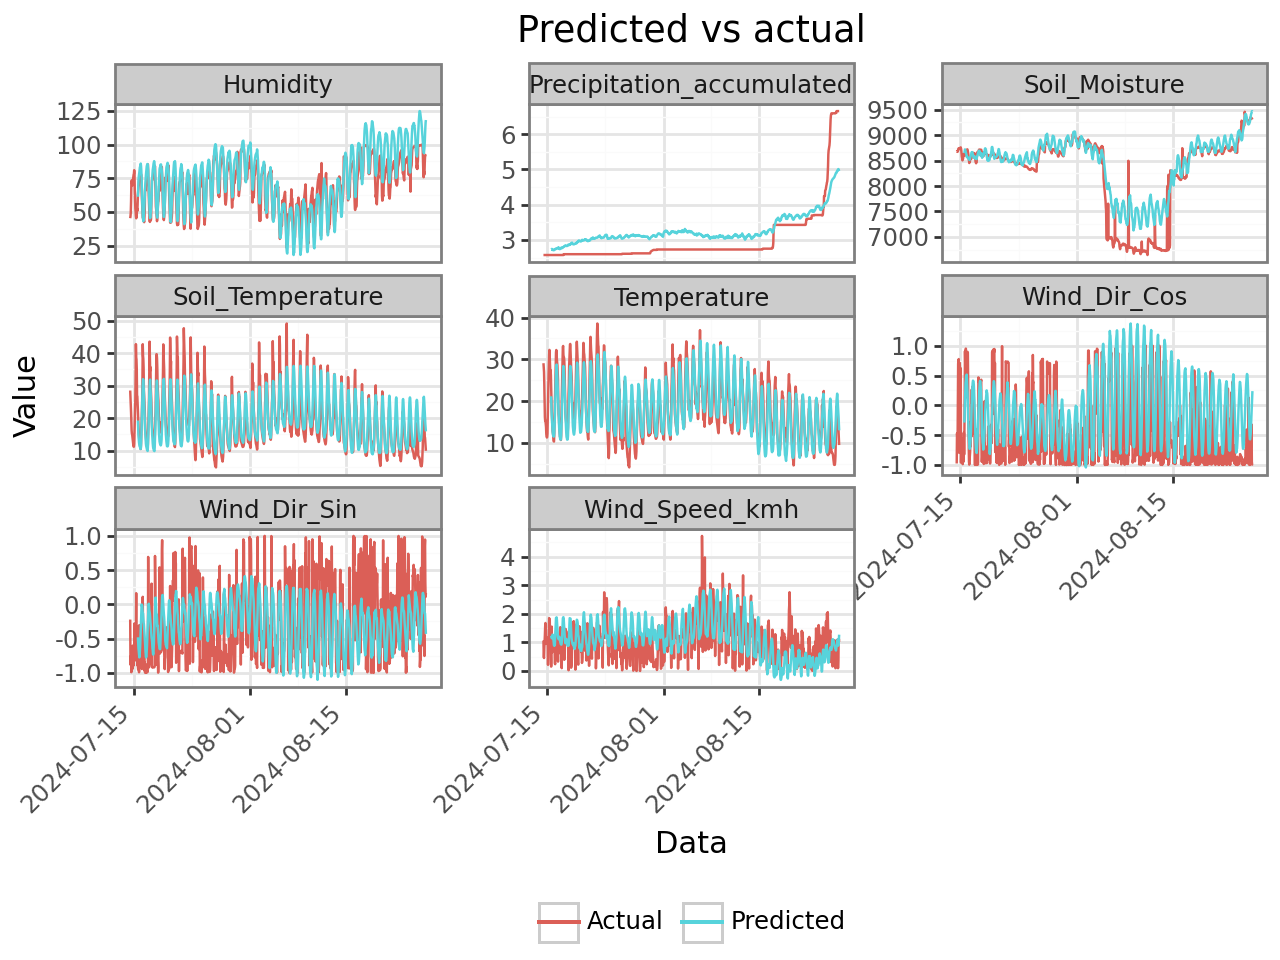

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [69]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

In [70]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

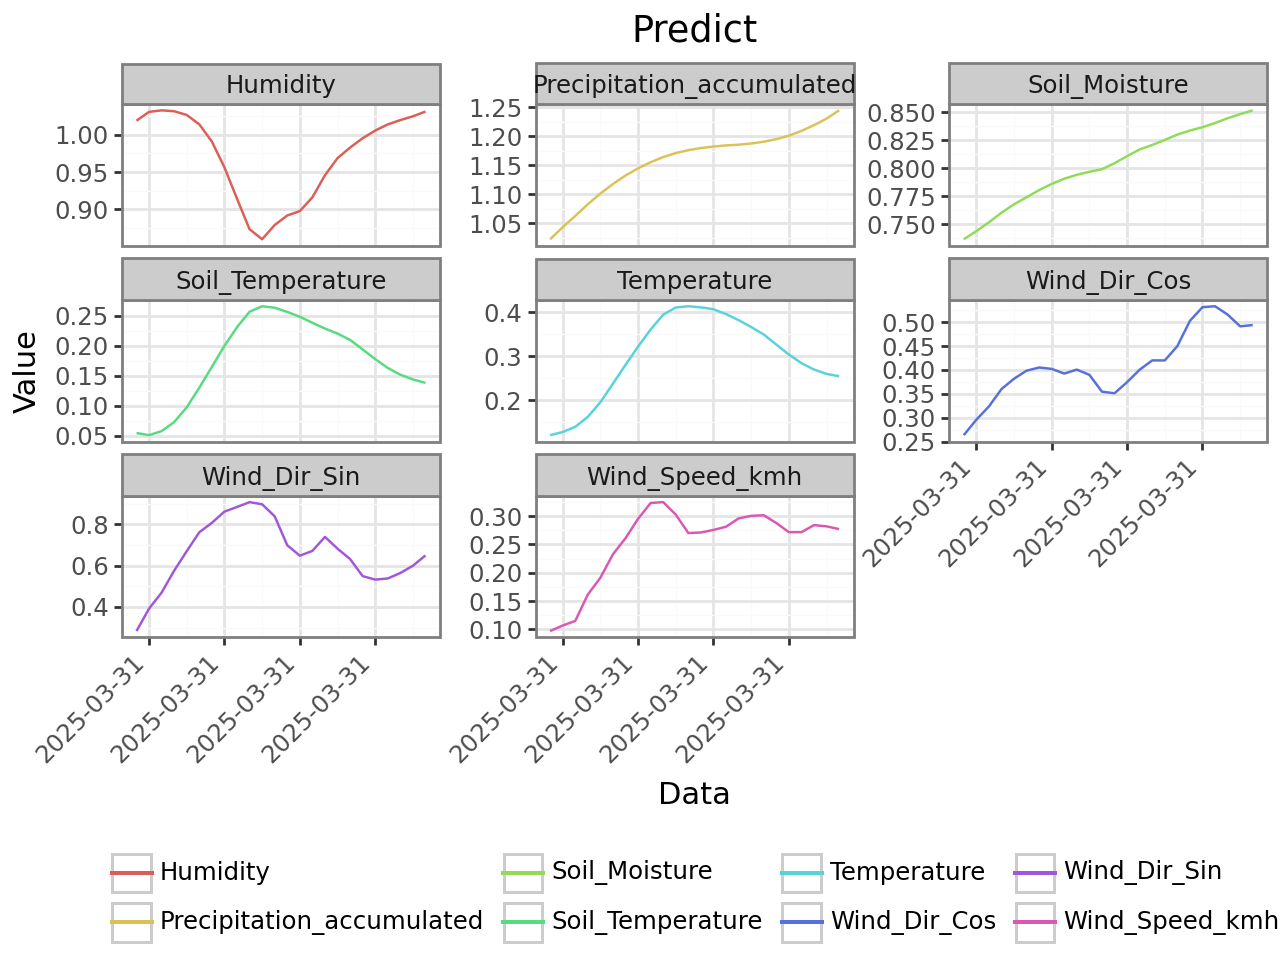

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_24.png


In [71]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Predict',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),

    )
)
plot.show()
plot.save('predict_24.png', width=12, height=10, dpi=300)

In [72]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)